In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import math
import pandas as pd  
import seaborn as sns

In [18]:
# [[chromStartPosition  chromEndPosition  Value]...]
def read_bedgraph(path):
    return np.loadtxt(path, usecols=range(1,4), dtype=int)

# [[chromStartPosition  chromEndPosition]...]
def get_bedG_ranges(bed_columns):
    return bed_columns[: , 0:2]

# [ chromEndPosition-chromStartPosition, ...]
def get_bedG_ranges_size(bed_columns):
    ranges = get_bedG_ranges(bed_columns)
    result = np.zeros(len(ranges))
    for i in range(len(ranges)):
        result[i] = int(ranges[i][1]-ranges[i][0])    #Aj tak mi tam da floaty 
    return result
    #return np.array(result, dtype=int)

# [value, ...]
def get_bedG_scores(bed_columns):
    return bed_columns[:,2]


# vrati najvacsiu chromEndPosition
def get_bedG_maxPosition(bed_columns):
    return bed_columns[len(bed_columns)-1][1]



In [12]:
bed1_columns = read_bedgraph('C:\\Users\\Evi\\Documents\\2INF-LETO\\RP\\ref-miseq.bedgraph')
bed2_columns = read_bedgraph('C:\\Users\\Evi\\Documents\\2INF-LETO\\RP\\ref-nanopore.bedgraph')

bed1_ranges = get_bedG_ranges(bed1_columns)
bed1_score = get_bedG_scores(bed1_columns)   

bed2_ranges = get_bedG_ranges(bed2_columns)
bed2_score = get_bedG_scores(bed2_columns)   


In [13]:
from DrawDistributions import draw

def drawHistogramsForReads(ranges, score, title='Title', x_axis_name='x axis', y_axis_name='y axis'):
    if len(ranges) != len(score):
        raise ValueError('Wrong files, the length of arrays should be equal')

    # Zadaj limitu pre os x:
    max_x=100

    #spravim histogram a zobrazim ho pomocou draw
    histo = {}
    for i in range(len(ranges)) :
        if int(score[i]) in histo:
            histo[int(score[i])] += (int(ranges[i][1])-int(ranges[i][0]))
        else:
            histo[int(score[i])] = (int(ranges[i][1])-int(ranges[i][0]))
    # treba vymazat 0, inak to pada
    if 0 in histo:
        del histo[0]
    data = draw(histo, max_x, title, x_axis_name, y_axis_name)
    #print(len(histo))    
    print('Maximum number of reads:', max(histo))

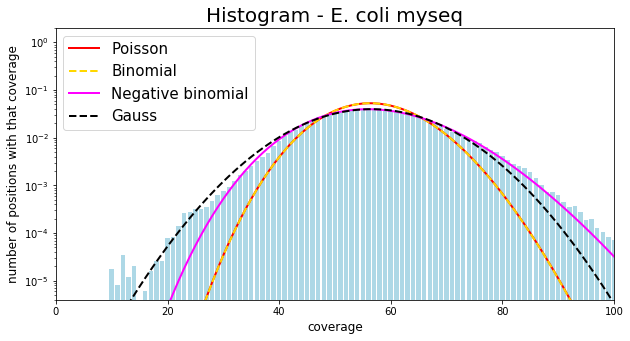

Maximum number of reads: 107


In [14]:
drawHistogramsForReads(bed1_ranges, bed1_score, title='Histogram - E. coli myseq', 
                       x_axis_name='coverage', y_axis_name='number of positions with that coverage')

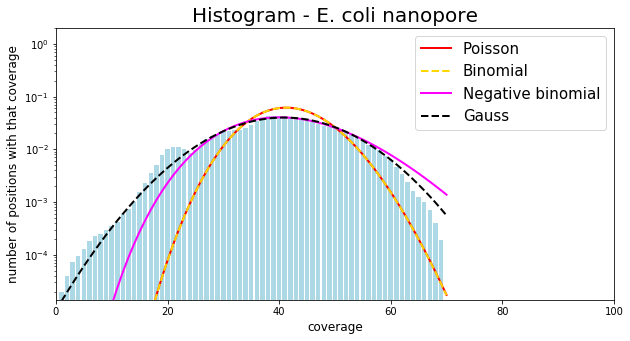

Maximum number of reads: 70


In [15]:
drawHistogramsForReads(bed2_ranges, bed2_score, title='Histogram - E. coli nanopore', 
                       x_axis_name='coverage', y_axis_name='number of positions with that coverage' )

In [16]:
#tu by som potrebovala aby bedG_range_sizes vracal inty

#function inserts bedG_range_sizes[i] times value bedG_scores[i] 
def filler(bedG_range_sizes, bedG_scores):
    return np.repeat(bedG_scores, bedG_range_sizes)

In [19]:
test_columns = read_bedgraph('C:\\Users\\Evi\\Documents\\2INF-LETO\\RP\\test.txt')
test_ranges = get_bedG_ranges(test_columns)
test_scores = get_bedG_scores(test_columns)
test_range_sizes = get_bedG_ranges_size(test_columns)

print(test_range_sizes)
print(test_scores)

vysledok = filler(np.array(test_range_sizes,dtype=int), test_scores)
print(vysledok)
print(len(vysledok))

[ 1. 10.  2.  1.  4.  2.  1.  4.  3.  3.  6.  1.  2.  1.]
[20 21 22 23 25 26 27 28 29 30 31 32 20 35]
[20 21 21 21 21 21 21 21 21 21 21 22 22 23 25 25 25 25 26 26 27 28 28 28
 28 29 29 29 30 30 30 31 31 31 31 31 31 32 20 20 35]
41


In [21]:
bg1 = filler(np.array(get_bedG_ranges_size(bed1_columns), dtype=int), bed1_score)
bg2 = filler(np.array(get_bedG_ranges_size(bed2_columns), dtype=int), bed2_score)

In [22]:
def make_heatmap(x, y, title='Heatmap', colorbar_title = 'values', x_axis_name='x', y_axis_name='y', are_integers=True):
    #predpokladam, ze tie mena chromozom su v rovnakom poradi a velkost suboru je rovanaka

    #bins = nasekat rovnomerne

    plt.figure(figsize=(20,10))  
    if are_integers:
        plt.hist2d(x, y,bins=(range(max(x)), range(max(y))), cmap='plasma')
    else:
        plt.hist2d(x, y,bins=(range(max(x)), np.linspace(min(y),max(y))), cmap='plasma')


    cb = plt.colorbar()
    cb.set_label(colorbar_title, fontsize=15)

    plt.title(title, fontsize=20)
    plt.xlabel(x_axis_name, fontsize=15)
    plt.ylabel(y_axis_name, fontsize=15)

    plt.show()

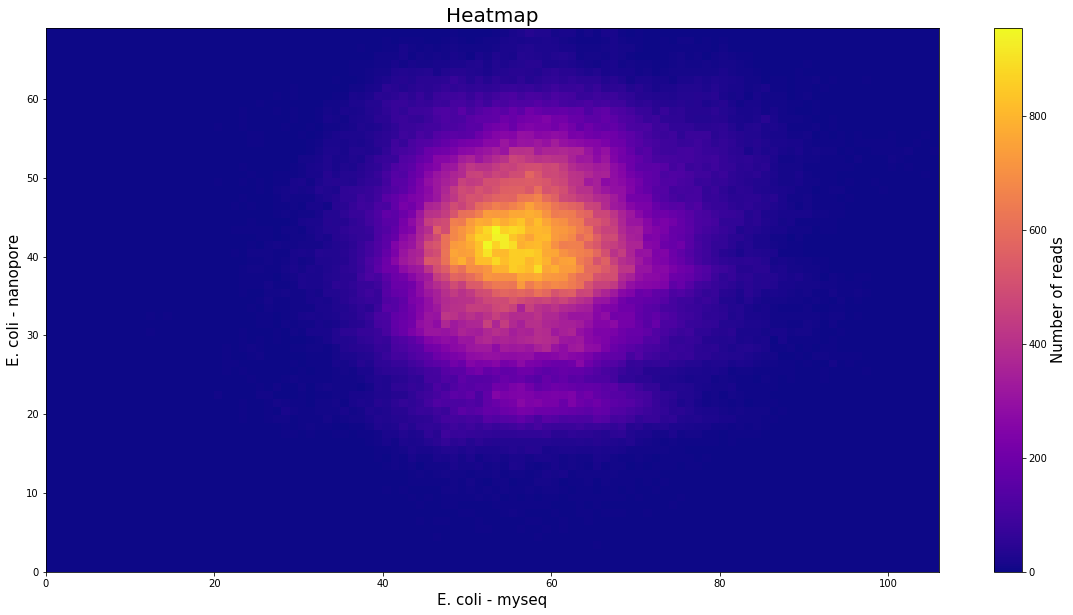

In [23]:
make_heatmap(bg1, bg2, title='Heatmap', colorbar_title = 'Number of reads',
             x_axis_name='E. coli - myseq', y_axis_name='E. coli - nanopore', are_integers=True)


In [24]:
def read_fasta_file(filename):
    data = []
    with open(filename) as fasta:
        for line in fasta: 
            if not line.startswith(">"):
                for c in line.strip():
                    data.append(c)
    print(len(data))
    return data

In [32]:
def create_values_from_fasta(fasta_data, kmer_length, function):
    if (kmer_length % 2 != 1):
        raise ValueError('The length of k-mer should be odd!')
    
    values = []

    half = int(kmer_length/2) 
    
    for i in range(len(fasta_data) - kmer_length +1):  # +1lebo ideme aj za posledne pismenko
        window = fasta_data[i:i+kmer_length]

        #ak su to kraje, tak napln half-krat values
        if i == 0 or i == (len(fasta_data) - kmer_length):
            # !!! pomale: values += [function(window)] * half
            values.extend(function(window) for i in range(half))
            
        #ak su to vnutorne casti
        if i >= 0 and i <= (len(fasta_data) - kmer_length):
            values.append(function(window))  
    return values
  

In [33]:
def count_GC(string):
    count = 0
    for c in string:
        if(c == 'G' or c == 'C'):
            count += 1
    return count

In [34]:
from scipy.stats import entropy

def count_entropy(string):
    length = len(string)
    if (length == 0):
        raise ValueError('Empty window!')
    probabilities = []
    probabilities.append(string.count('C')/length)
    probabilities.append(string.count('G')/length)
    probabilities.append(string.count('A')/length)
    probabilities.append(string.count('T')/length)

    return entropy(probabilities, base=2)

In [35]:
string = ['A', 'G', 'C', 'A', 'A', 'T', 'A', 'G', 'C', 'A', 'G', 'A']
print(count_entropy(string))

1.7295739585136227


In [36]:
fasta_data = read_fasta_file('C:\\Users\\Evi\\Documents\\2INF-LETO\\RP\\fasta-test.txt')
got_values = create_values_from_fasta(fasta_data, 21, count_GC)
expected = [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 14, 13, 12, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
ok = True
for i in range(len(expected)):
    if(expected[i]!=got_values[i]):
        ok=False

if(ok):
    print("TEST OK")
else:
    print("TEST FAILED")
    print("Expected:", expected)
    print("Got:     ", got_values)

32
TEST OK


500000


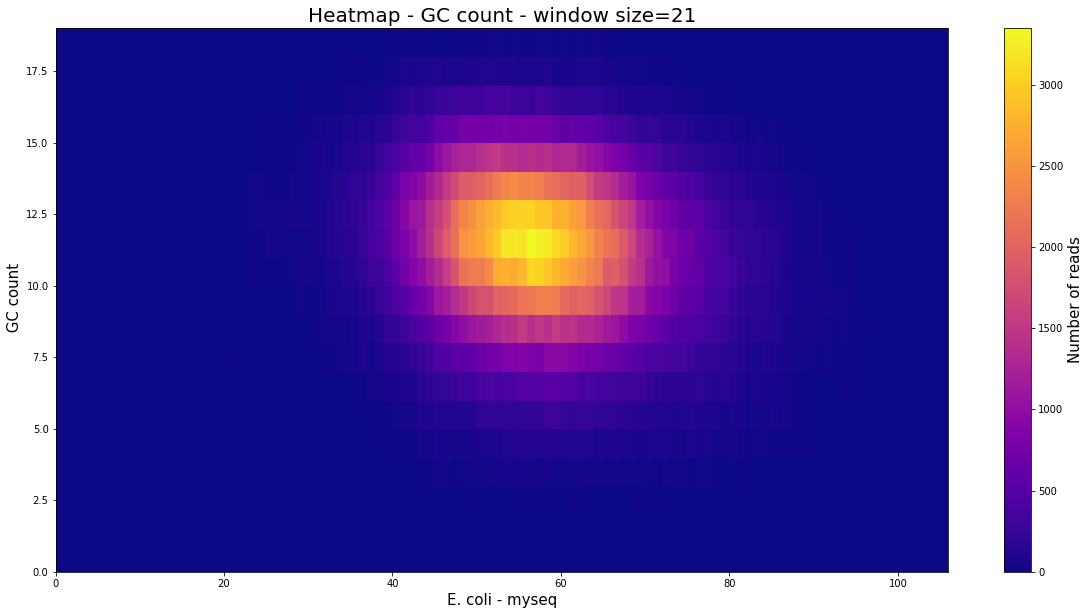

In [37]:
fasta_data = read_fasta_file('C:\\Users\\Evi\\Documents\\2INF-LETO\\RP\\ref.fasta')
values = create_values_from_fasta(fasta_data, 21, count_GC)

make_heatmap(bg1, values, title='Heatmap - GC count - window size=21', colorbar_title = 'Number of reads',
             x_axis_name='E. coli - myseq', y_axis_name=' GC count', are_integers=True)


In [38]:
def make_boxplot(x, y, title='Boxplot',  x_axis_name='x', y_axis_name='y'):
    plt.figure(figsize=(50,30))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=30)
    plt.title(title, fontsize=80)
    plt.xlabel(x_axis_name, fontsize=50)
    plt.ylabel(y_axis_name, fontsize=50)
    sns.boxplot(x=x, y=y)
    plt.show

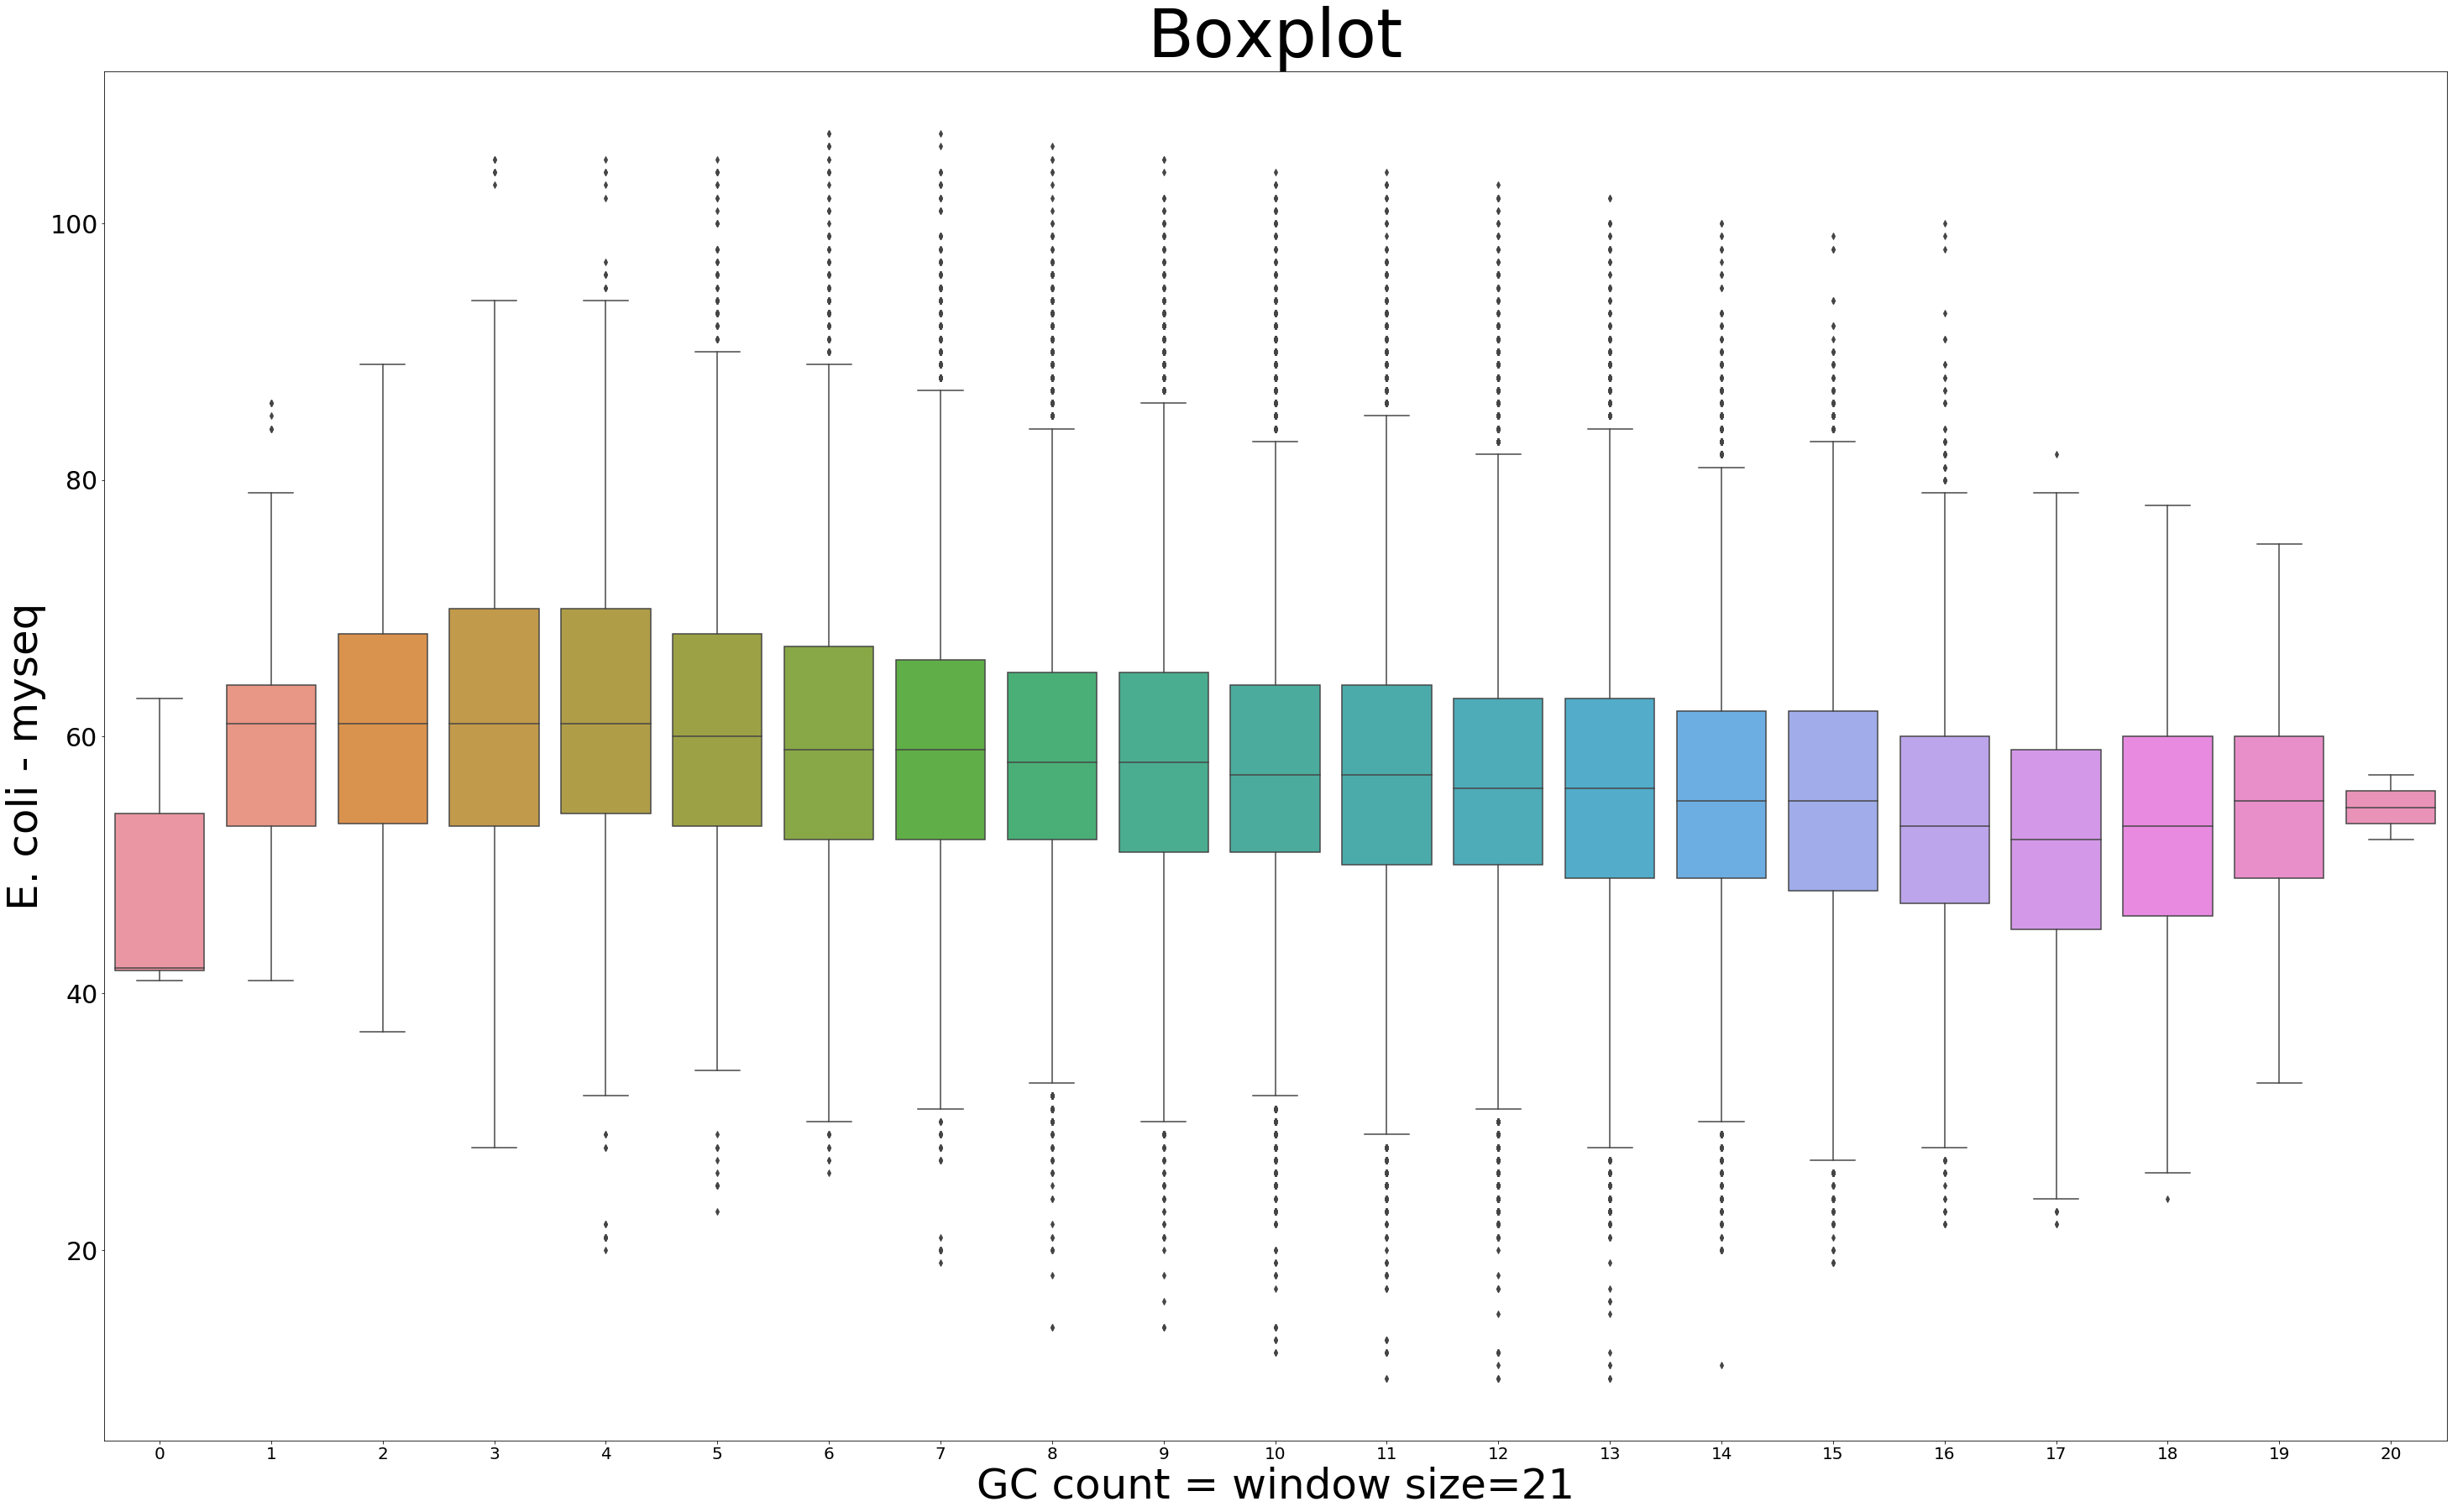

In [39]:
make_boxplot(x=values, y=bg1, title='Boxplot',  x_axis_name='GC count = window size=21', y_axis_name='E. coli - myseq')

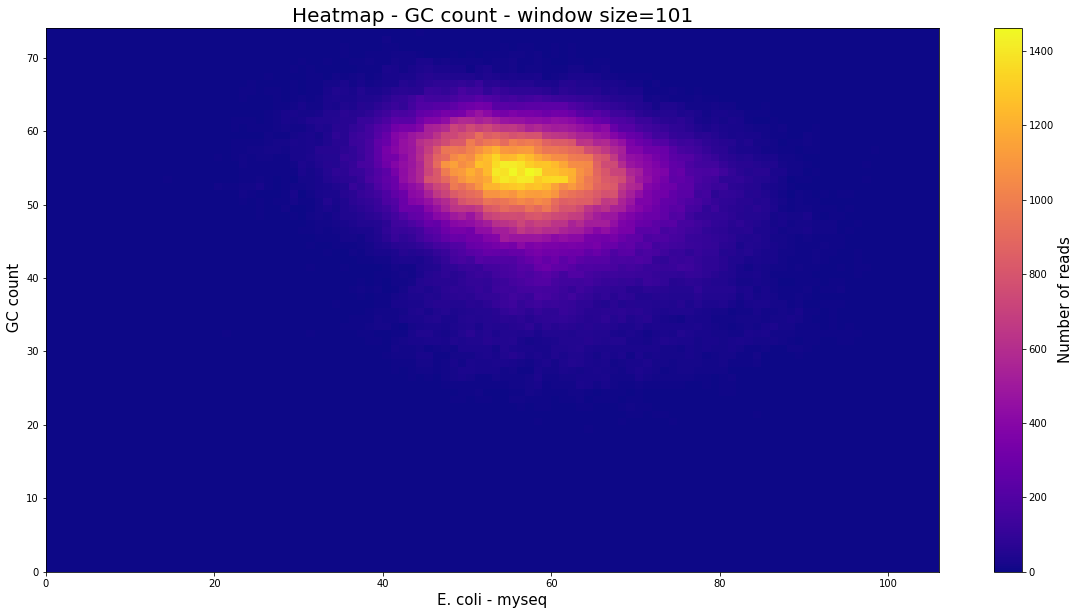

In [40]:
values = create_values_from_fasta(fasta_data, 101, count_GC)

make_heatmap(bg1, values, title='Heatmap - GC count - window size=101', colorbar_title = 'Number of reads',
             x_axis_name='E. coli - myseq', y_axis_name=' GC count', are_integers=True)

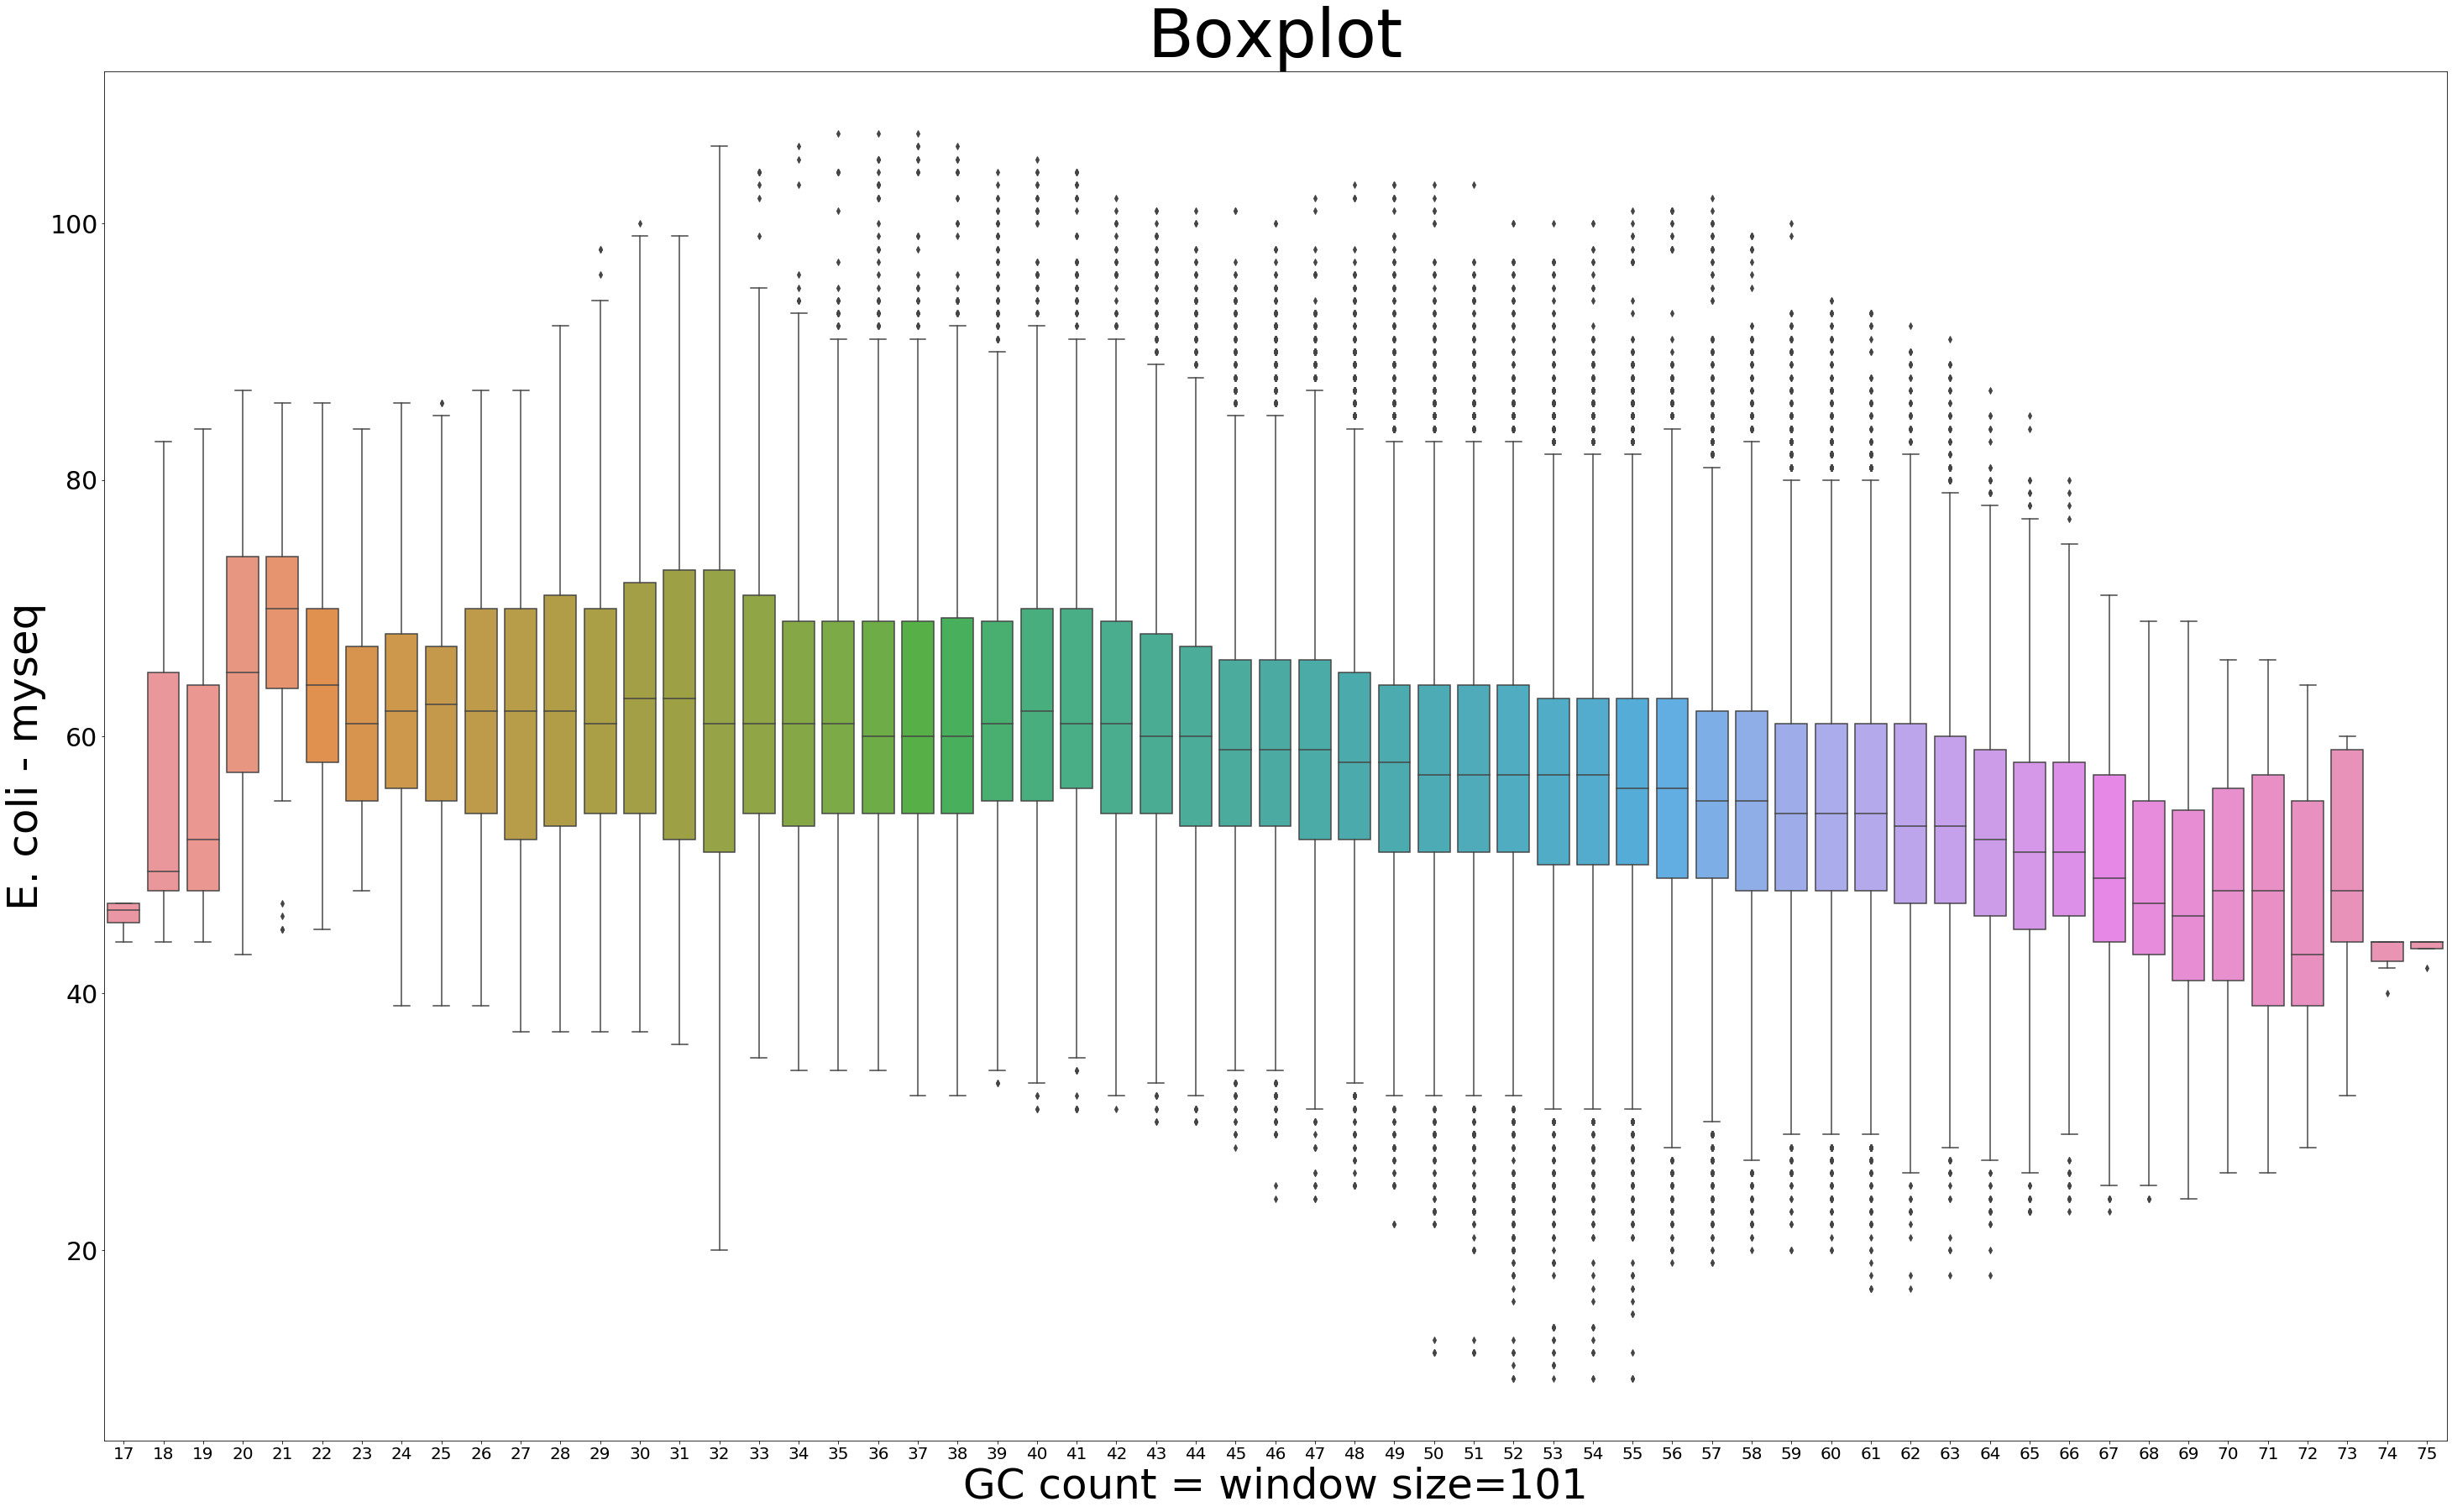

In [41]:
make_boxplot(x=values, y=bg1, title='Boxplot',  x_axis_name='GC count = window size=101', y_axis_name='E. coli - myseq')

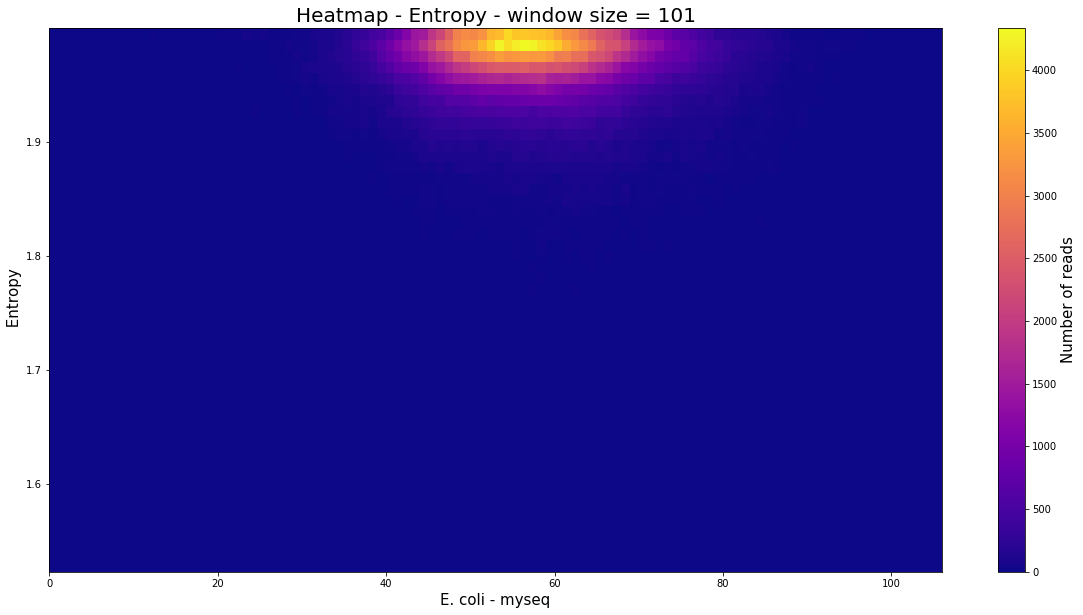

In [42]:
values = create_values_from_fasta(fasta_data, 101, count_entropy)

make_heatmap(bg1, values, title='Heatmap - Entropy - window size = 101', colorbar_title = 'Number of reads',
             x_axis_name='E. coli - myseq', y_axis_name=' Entropy', are_integers=False)

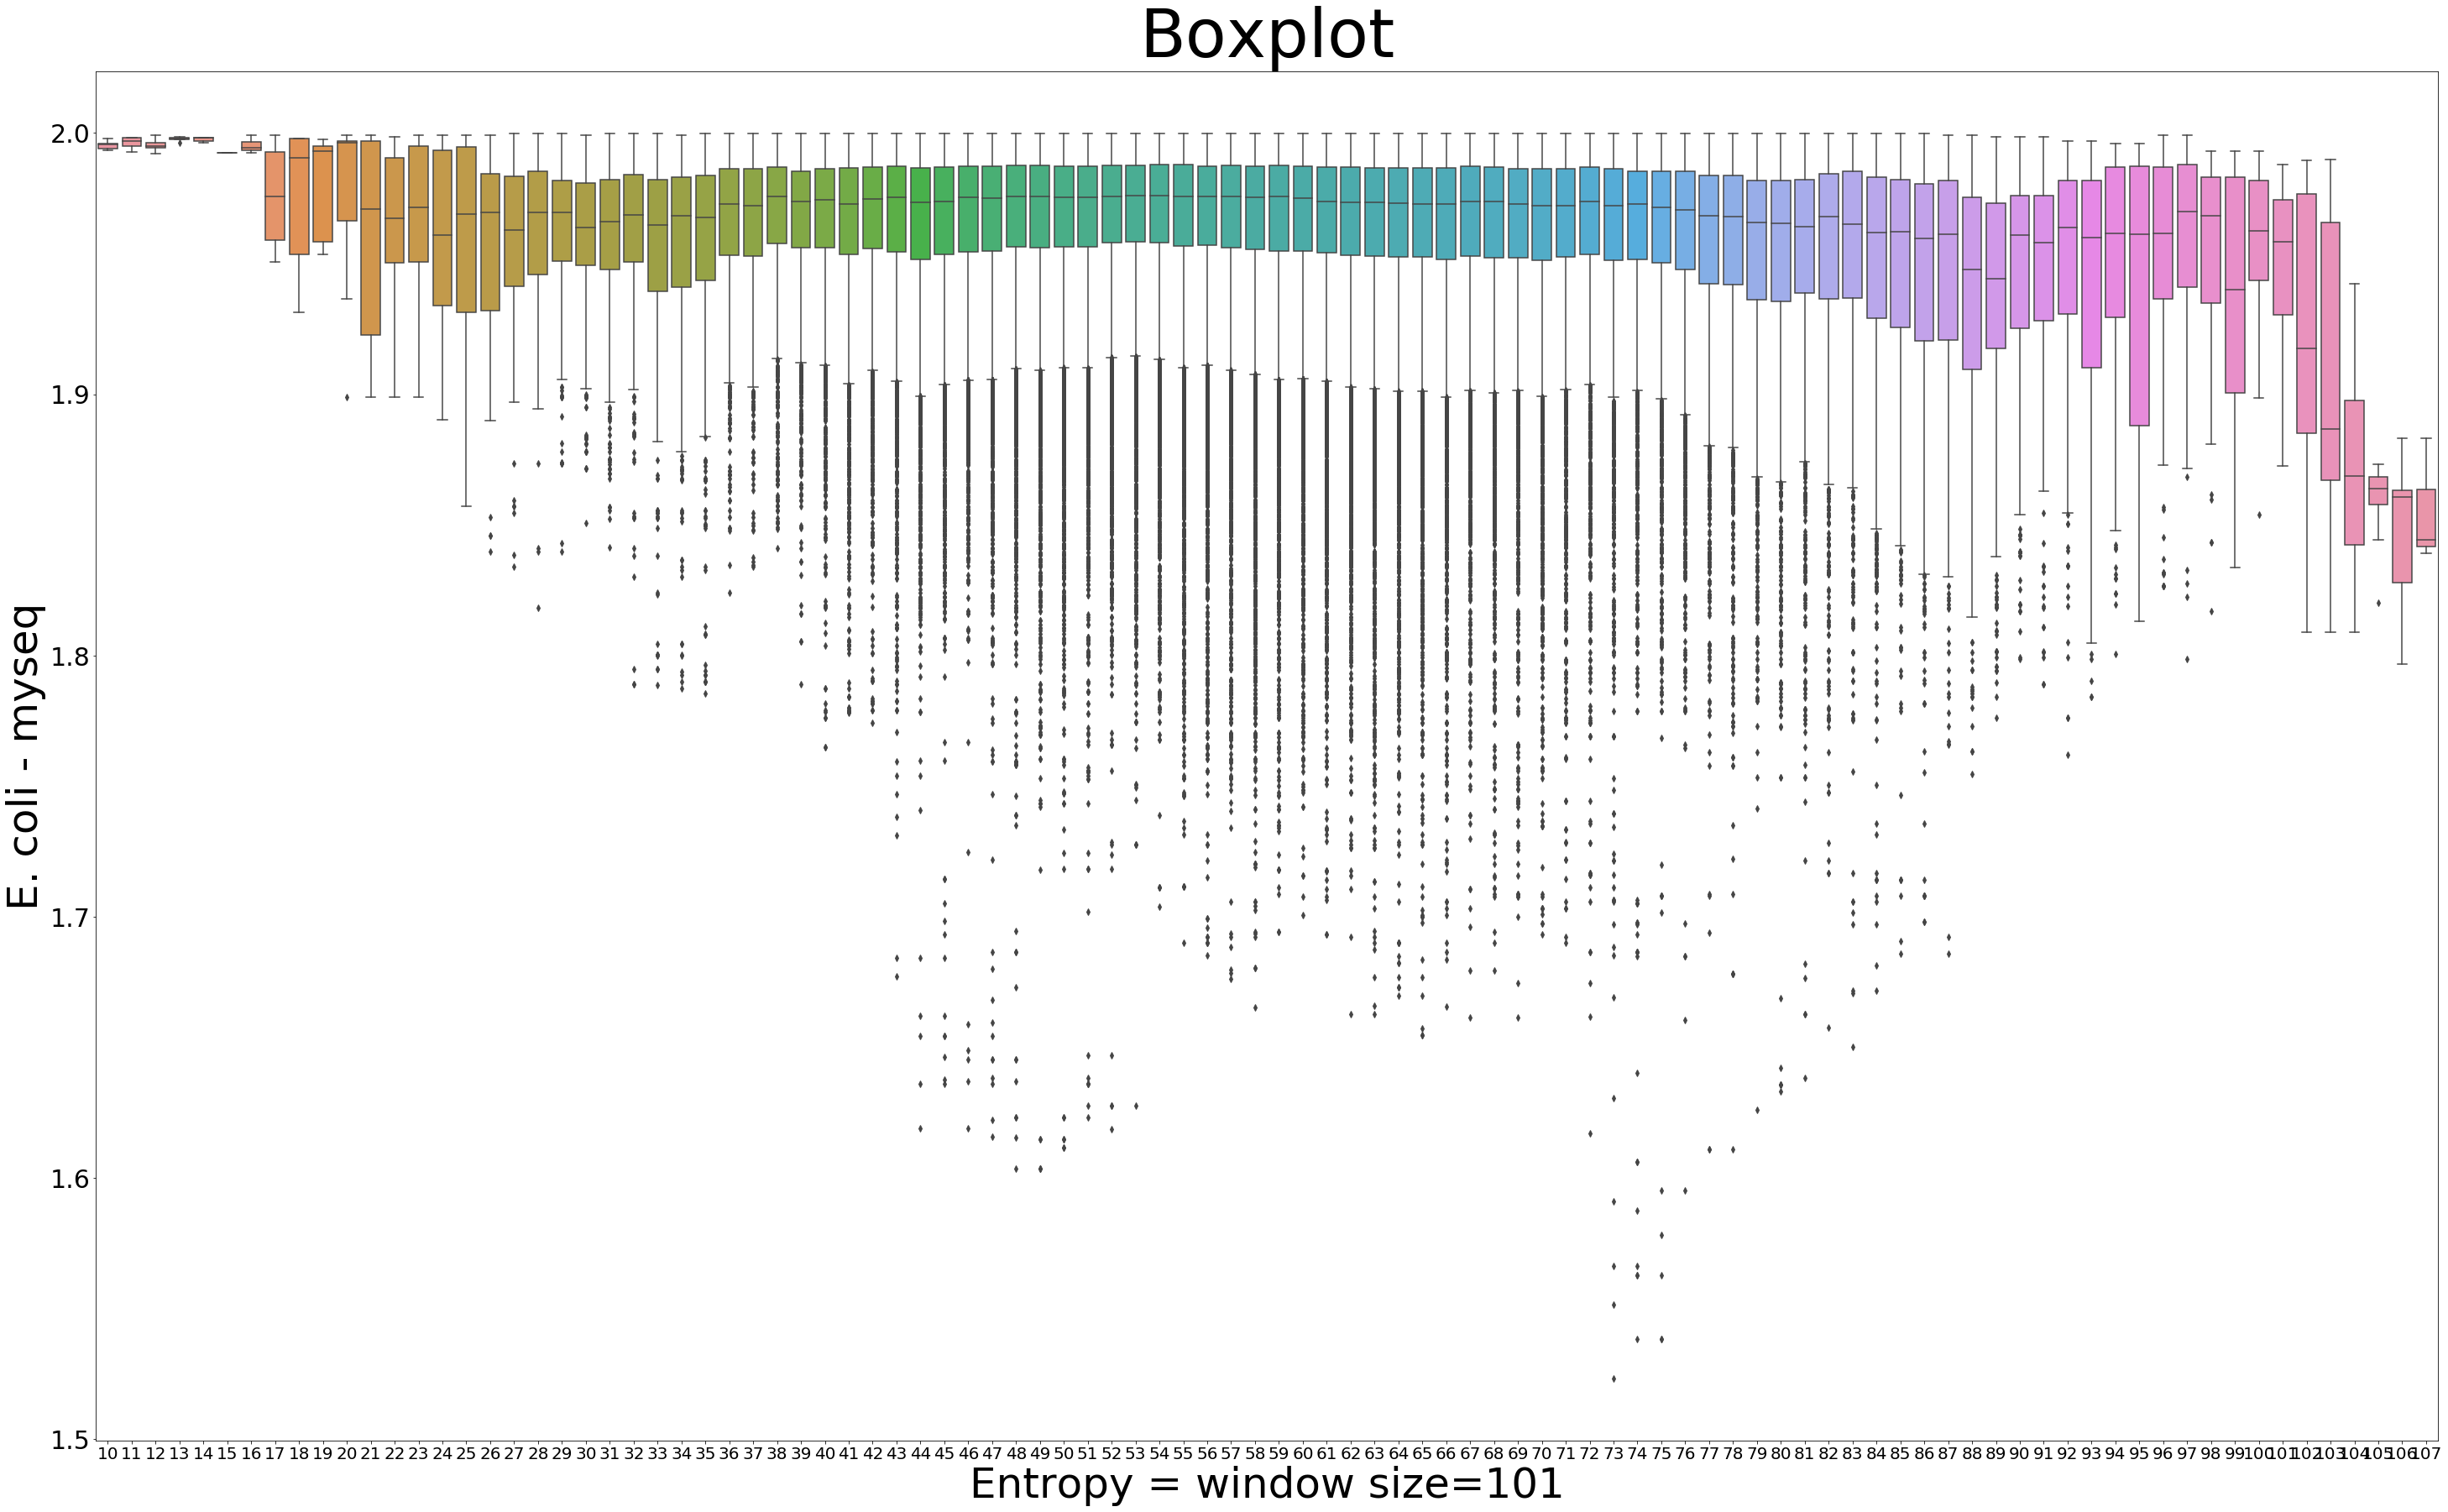

In [43]:
make_boxplot(x=bg1, y=values, title='Boxplot',  x_axis_name='Entropy = window size=101', y_axis_name='E. coli - myseq')

In [17]:
print(bed1_columns)
print(len(bed1_columns))
scores = bed1_columns[:,2]
print(scores)

ranges = get_bedG_ranges(bed1_columns)
print(ranges)
print(len(ranges))

result = np.zeros(len(ranges))
print(result)
print(len(result))


for i in range(len(ranges)):
    result[i] = ranges[i][1]-ranges[i][0]

print(result)
print(get_bedG_maxPosition(bed1_columns))

temp = get_bedG_scores(bed1_columns)
print(temp[:10])

[[     0      1     20]
 [     1     11     21]
 [    11     13     22]
 ...
 [499976 499980     22]
 [499980 499986     21]
 [499986 500000     20]]
230387
[20 21 22 ... 22 21 20]
[[     0      1]
 [     1     11]
 [    11     13]
 ...
 [499976 499980]
 [499980 499986]
 [499986 500000]]
230387
[0. 0. 0. ... 0. 0. 0.]
230387
[ 1. 10.  2. ...  4.  6. 14.]
500000
[20 21 22 23 25 26 27 28 29 30]
